In [1]:
# All necessary imports
library(rtracklayer)
library(Rsamtools)
library(GenomicAlignments)
library(DESeq2)
library(EnhancedVolcano)
library(goseq)
library(pheatmap)
library(RColorBrewer)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: Biostrings

Loading required package: XVector


Attachin

# Count matrices

STAR and other aligners generate bam files with information about the reads mapping to genomic co-ordinates. Count matrix generation is the process of using this data to generate a matrix of gene expression counts for each sample. In addition to the bam files, we also need transcript information which is available through gtf files. GTF files for all organisms can be downloaded using [ENSEMBL](https://www.ensembl.org/index.html?redirect=no). <b> Important </b>: Make sure that the genome index and gtf file are from the same version of the genome. Current version of the human genome is [GRCH38/hg38](https://www.ensembl.org/Homo_sapiens/Info/Index) and the mouse genome is [GRCm39/mm10](https://www.ensembl.org/Mus_musculus/Info/Index). 

## Data - BAM files

We will use a small dataset to practice count matrix generation. The data is from the `Pasilla` [knockdown experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3032923/). We have bam files from two untreated samples available [here](https://drive.google.com/file/d/1VWvwatiE4WbMpocCm3W1rdCtakkqdAI6/view?usp=sharing). The bam files were subset to include only `chr4`. Copy the bam files over to the `data` directory 


In [2]:
dir('data/', pattern='bam')

[1] "untreated1_chr4.bam" "untreated3_chr4.bam"

## GTF file
Lets download the GTF file. The bams were generated using `Release 62` of the Drosophila genome.


In [3]:
# This URL can be copied over from ENSEMBL
fl <- paste0("ftp://ftp.ensembl.org/pub/release-62/gtf/drosophila_melanogaster/Drosophila_melanogaster.BDGP5.25.62.gtf.gz")

# Create a destination file name 
gffFile <- file.path('data/', basename(fl))
print(gffFile)

# Download the gtf file to the data directory
download.file(fl, gffFile)


[1] "data//Drosophila_melanogaster.BDGP5.25.62.gtf.gz"


In [4]:
# Verify that the file is downloaded 
dir('data/')


[1] "Drosophila_melanogaster.BDGP5.25.62.gtf.gz"
[2] "tcga_gbm_clean_counts.csv"                 
[3] "tcga_gbm_clean_patient_metadata.csv"       
[4] "tcga_gbm_full_counts.csv"                  
[5] "tcga_gbm_full_patient_metadata.csv"        
[6] "untreated1_chr4.bam"                       
[7] "untreated3_chr4.bam"

Next step is to load the gtf file into R. We will use the `rtracklayer` package for importing the gtf file

In [5]:
gff0 <- import(gffFile)

Examine the `gtf` file. As you will see, the imported gtf is a `GRanges` object with all the relevant information about transcript definition. 

In [6]:
gff0

GRanges object with 269500 ranges and 10 metadata columns:
           seqnames            ranges strand |         source        type
              <Rle>         <IRanges>  <Rle> |       <factor>    <factor>
       [1]       3R           380-509      + | protein_coding exon       
       [2]       3R          578-1913      + | protein_coding exon       
       [3]       3R         1115-1913      + | protein_coding CDS        
       [4]       3R         1115-1117      + | protein_coding start_codon
       [5]       3R         7784-8649      + | protein_coding exon       
       ...      ...               ...    ... .            ...         ...
  [269496]       2L 22959877-22960833      - | protein_coding  exon      
  [269497]       2L 22959877-22960833      - | protein_coding  CDS       
  [269498]       2L 22959601-22959815      - | protein_coding  exon      
  [269499]       2L 22959724-22959815      - | protein_coding  CDS       
  [269500]       2L 22959721-22959723      - | protei

### GRanges refresher exercise


In [7]:
# What are the different source of genes in the gff?
unique(gff0$source)

# What are the different entry `type`s
unique(gff0$type)

[1] protein_coding pseudogene     snRNA          tRNA           snoRNA        
[6] ncRNA          miRNA          rRNA          
Levels: protein_coding pseudogene snRNA tRNA snoRNA ncRNA miRNA rRNA

[1] exon        CDS         start_codon stop_codon 
Levels: exon CDS start_codon stop_codon

Since our bam files contain data from `chr4` only, subset the gff to contain genes from only chromosome 4. Note that this is not strictly necessary, but will only speed up the processing. This will also give you an idea of how to subset different gene sets of interest if you do not need to generate a full count matrix. 

In [8]:
# Exons from protein coding genes in chromosome 4
idx <- mcols(gff0)$source == "protein_coding" &
            mcols(gff0)$type == "exon" &
            seqnames(gff0) == "4"
gff <- gff0[idx]
# Adjust seqnames to match Bam files. This is important because bam files have seqnames as "chr1", "chr2", etc whereas ENSEMBL gtfs have seqnames as "1", "2". 
seqlevels(gff) <- paste("chr", seqlevels(gff), sep="")


Verify that your filtering worked:

In [9]:
unique(gff$source)
unique(gff$type)
unique(seqnames(gff))

[1] protein_coding
Levels: protein_coding pseudogene snRNA tRNA snoRNA ncRNA miRNA rRNA

[1] exon
Levels: exon CDS start_codon stop_codon

[1] chr4
14 Levels: chr2L chr2R chr3L chr3R chr4 chrX chrU chr2LHet ... chrdmel_mitochondrion_genome

Final step: We need to group the codons by gene id / gene name / transcript id

In [10]:
chr4genes <- split(gff, mcols(gff)$gene_id)

# Length will equal to number of genes
length(chr4genes)

# Names of genes
names(chr4genes)


[1] 82

[1] "FBgn0002521" "FBgn0004607" "FBgn0004624" "FBgn0004859" "FBgn0005558"
 [6] "FBgn0005561" "FBgn0005666" "FBgn0010217" "FBgn0011642" "FBgn0011747"
[11] "FBgn0013749" "FBgn0016126" "FBgn0017545" "FBgn0019650" "FBgn0019985"
[16] "FBgn0022361" "FBgn0023213" "FBgn0024728" "FBgn0024811" "FBgn0024913"
[21] "FBgn0025726" "FBgn0025740" "FBgn0025741" "FBgn0025936" "FBgn0026199"
[26] "FBgn0026262" "FBgn0026777" "FBgn0026869" "FBgn0027101" "FBgn0028996"
[31] "FBgn0039889" "FBgn0039890" "FBgn0039896" "FBgn0039897" "FBgn0039900"
[36] "FBgn0039902" "FBgn0039904" "FBgn0039905" "FBgn0039907" "FBgn0039908"
[41] "FBgn0039909" "FBgn0039911" "FBgn0039914" "FBgn0039915" "FBgn0039916"
[46] "FBgn0039920" "FBgn0039923" "FBgn0039924" "FBgn0039925" "FBgn0039927"
[51] "FBgn0039928" "FBgn0039929" "FBgn0039930" "FBgn0039932" "FBgn0039936"
[56] "FBgn0039937" "FBgn0039938" "FBgn0039939" "FBgn0040037" "FBgn0040324"
[61] "FBgn0042696" "FBgn0051992" "FBgn0051997" "FBgn0051998" "FBgn0051999"
[66] "FBgn0052000" "FBgn0052006" "FBgn0052016" "FBgn0052017" "FBgn0052021"
[71] "FBgn0052850" "FBgn0053481" "FBgn0053653" "FBgn0053797" "FBgn0053978"
[76] "FBgn0067895" "FBgn0069921" "FBgn0085432" "FBgn0087002" "FBgn0250819"
[81] "FBgn0259214" "FBgn0259216"

<b> Quick exercise </b></br>

In [11]:
# Extract coding sequences from protein coding genes on chromosome 5

In [12]:
# Extract pseudodgenes and tRNAs from all chromosomes

## Let's count!

In [13]:
# Define bam parameters using `ScanBamParam`
param <- ScanBamParam(
              what='qual',
              which=GRanges("chr4", IRanges(1, 1e6)),
              flag=scanBamFlag(isUnmappedQuery=FALSE, isPaired=NA),
 tag="NH")

# Bam files 
bamFiles <- c("data/untreated1_chr4.bam", "data/untreated3_chr4.bam")


`summarizeOverlaps` from `GenomicAlignments` package is the function to use for creating count matrices

In [14]:
genehits <- summarizeOverlaps(chr4genes, bamFiles, mode="Union")
genehits


R_zmq_msg_send errno: 4 strerror: Interrupted system call

R_zmq_msg_send errno: 4 strerror: Interrupted system call



class: RangedSummarizedExperiment 
dim: 82 2 
metadata(0):
assays(1): counts
rownames(82): FBgn0002521 FBgn0004607 ... FBgn0259214 FBgn0259216
rowData names(0):
colnames(2): untreated1_chr4.bam untreated3_chr4.bam
colData names(0):

`geneHits` is an object of `RangedSummarizedExperiment`. `SummarizedExperiment` is a class for holding counts and other matrices along with metadata information about the samples, genes and the experiment itself. An illustration of `SummarizedExperiment` is shown below. More details [here](https://bioconductor.org/packages/release/bioc/vignettes/SummarizedExperiment/inst/doc/SummarizedExperiment.html). 

![](assets/SummarizedExperiment.jpg)

`RangedSummarizedExperiment` is same as `SummarizedExperiment` such that the row data is a `GRanges` object. In this case features are genes. Examine the counts, sample information and gene information 


In [15]:
head(assays(genehits)[['counts']])

,untreated1_chr4.bam,untreated3_chr4.bam
FBgn0002521,346,210
FBgn0004607,7,6
FBgn0004624,587,421
FBgn0004859,192,96
FBgn0005558,4,12
FBgn0005561,4,5


In [16]:
head(rownames(genehits))

[1] "FBgn0002521" "FBgn0004607" "FBgn0004624" "FBgn0004859" "FBgn0005558"
[6] "FBgn0005561"

In [17]:
colnames(genehits)

[1] "untreated1_chr4.bam" "untreated3_chr4.bam"


`SummarizedExperiment` can be subset by rows or columns

<b>Important</b> A key parameter in `summarizeOverlaps` is `mode`. `Union` is a general safe bet.
![](assets/summarizeoverlaps.jpg)


# Differential analysis

Differential analysis is used to identify differentially expressed genes in different conditions. We will use the [TCGA Glioblastoma](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/glioblastoma) dataset for differential analysis.  The dataset contains a total of 114 patient samples and is annotated as the following subtypes: Proneural, Neural, Mesenchymal and G-CIMP. The counts data is available [here](https://drive.google.com/file/d/1aaV8QFcRPXF3oOzGdwKpqmRWyd4DrMKN/view?usp=sharing) and the patient metadata (subtypes) is available [here](https://drive.google.com/file/d/1NcGZcyhpJ1QxUGL4aYpe7KsPLUXfQ9Kd/view?usp=sharing).


## Load the data 

In [18]:
# These are simple csv files, which we will load using read.csv 
# Make sure to set check.names to FALSE - R annoyingly resets special characters to dots
counts <- read.csv('data/tcga_gbm_clean_counts.csv', check.names=FALSE, row.names=1)
metadata <- read.csv('data/tcga_gbm_clean_patient_metadata.csv', check.names=FALSE, row.names=1)


Examine the data - we will just look at a few things to make sure all looks good

In [19]:
# Dimensionality of the counts and metadata should match
dim(counts)
dim(metadata)

# Sample names should be same 
sum(colnames(counts) != rownames(metadata))

head(metadata)


[1] 23852   114

[1] 114   4

[1] 0

,barcode,sample,tissue_type,Subtype
,<chr>,<chr>,<chr>,<chr>
TCGA-02-0055-01A-01R-1849-01,TCGA-02-0055-01A-01R-1849-01,TCGA-02-0055-01A,Not Reported,Mesenchymal
TCGA-12-0821-01A-01R-1849-01,TCGA-12-0821-01A-01R-1849-01,TCGA-12-0821-01A,Not Reported,Neural
TCGA-27-1831-01A-01R-1850-01,TCGA-27-1831-01A-01R-1850-01,TCGA-27-1831-01A,Not Reported,Neural
TCGA-06-0132-01A-02R-1849-01,TCGA-06-0132-01A-02R-1849-01,TCGA-06-0132-01A,Not Reported,Neural
TCGA-76-4927-01A-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4927-01A,Not Reported,Neural
TCGA-06-2569-01A-01R-1849-01,TCGA-06-2569-01A-01R-1849-01,TCGA-06-2569-01A,Not Reported,Mesenchymal


There are four different subtypes of GBM samples in this dataset: Mesenchymal, Neural, G-CIMP, Proneural

In [20]:
unique(metadata[, 'Subtype'])

[1] "Mesenchymal" "Neural"      "G-CIMP"      "Proneural"

## SummarizedExperiment

We will first create a `SummarizedExperiment` object which will contain all the information we need


In [21]:
gbmSE <- SummarizedExperiment(assays = list(counts = as.matrix(counts)), colData = metadata)
gbmSE


class: SummarizedExperiment 
dim: 23852 114 
metadata(0):
assays(1): counts
rownames(23852): TSPAN6 TNMD ... LINC01144 AC007389.5
rowData names(0):
colnames(114): TCGA-02-0055-01A-01R-1849-01
  TCGA-12-0821-01A-01R-1849-01 ... TCGA-41-5651-01A-01R-1850-01
  TCGA-06-0646-01A-01R-1849-01
colData names(4): barcode sample tissue_type Subtype

Subset `gbmSE` to include only Proneural and Mesenchymal subtypes and call the new object ```gbmSE_sub```. 

In [22]:
gbmSE_sub = gbmSE[, colData(gbmSE)[, 'Subtype'] %in% c('Proneural', 'Mesenchymal')]
gbmSE_sub


class: SummarizedExperiment 
dim: 23852 80 
metadata(0):
assays(1): counts
rownames(23852): TSPAN6 TNMD ... LINC01144 AC007389.5
rowData names(0):
colnames(80): TCGA-02-0055-01A-01R-1849-01 TCGA-06-2569-01A-01R-1849-01
  ... TCGA-41-5651-01A-01R-1850-01 TCGA-06-0646-01A-01R-1849-01
colData names(4): barcode sample tissue_type Subtype

<b> Quick exercise </b></br>

In [23]:
# Create 'gbmSE_mes_neur' with Mesenchymal and Neural subtypes

## Differential analysis - simple

We will use `DESeq2` for differential analysis. Details about DESeq2 are available [here](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8). [edgeR](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2796818/) is another popular tool for differential analysis for bulk counts data. Practically, the differences are minimal and they generally both work well. A detailed tutorial of theory and extensive use-cases for DESeq2 is found [here](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). Lecture is based on almost entirely on the linked vignette.

As a start, lets identify differentially expressed genes between proneural and mesenchymal subtypes. First we need to set up a `DESeqDataSet`. The `design` parameter includes all the sample metadata that need to be used to identify differential expression (More on this later). Here, we only have one metadata ie. Subtype. This will go to the `design` parameter of `DESeqDataSet` function.


In [24]:
dds <- DESeqDataSet(gbmSE_sub, design = ~ Subtype)
dds

# Reset the levels to use proneural as reference 
dds$Subtype <- relevel(dds$Subtype, ref = "Proneural")


Warning message in DESeqDataSet(gbmSE_sub, design = ~Subtype):
"some variables in design formula are characters, converting to factors"


class: DESeqDataSet 
dim: 23852 80 
metadata(1): version
assays(1): counts
rownames(23852): TSPAN6 TNMD ... LINC01144 AC007389.5
rowData names(0):
colnames(80): TCGA-02-0055-01A-01R-1849-01 TCGA-06-2569-01A-01R-1849-01
  ... TCGA-41-5651-01A-01R-1850-01 TCGA-06-0646-01A-01R-1849-01
colData names(4): barcode sample tissue_type Subtype

Perform differential analysis. 

In [25]:
dds <- DESeq(dds)
res <- results(dds)
mes_vs_pro_pairwise = res

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 654 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



<b>Done!</b>

Since we used proneural subtype as reference, genes with negative fold change are higher in proneural and genes with positive fold changes are higher in mesenchymal. Examine the top differentially expressed genes in each condition


In [26]:
# Sort by adjusted p-values 
resOrdered <- res[order(res$padj),]

# Top 10 proneural genes
head(resOrdered[resOrdered[, 'log2FoldChange'] < 0,  ])


# Top 10 mesenchymal genes
head(resOrdered[resOrdered[, 'log2FoldChange'] > 0,  ])


log2 fold change (MLE): Subtype Mesenchymal vs Proneural 
Wald test p-value: Subtype Mesenchymal vs Proneural 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
LINC02283   188.174       -4.51217  0.362546  -12.4458 1.47402e-35 3.51582e-31
MARCH9     7381.968       -3.75206  0.311184  -12.0574 1.77374e-33 2.11536e-29
CYP27B1     598.988       -4.14231  0.366724  -11.2955 1.38175e-29 1.09859e-25
CDK4      26572.192       -3.54445  0.317117  -11.1771 5.27825e-29 3.14742e-25
AGAP2      7103.471       -3.84978  0.346251  -11.1185 1.02015e-28 4.86650e-25
B4GALNT1   4689.123       -3.44770  0.336826  -10.2359 1.36976e-24 5.44526e-21

log2 fold change (MLE): Subtype Mesenchymal vs Proneural 
Wald test p-value: Subtype Mesenchymal vs Proneural 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
LTBP2    1386.662       1.966261  0.201575   9.75450 1.76460e-22 4.67658e-19
CYP1B1   1485.611       2.887486  0.299538   9.63981 5.42877e-22 1.29487e-18
APCDD1L   224.841       4.603045  0.478652   9.61668 6.79916e-22 1.47431e-18
IGFBP6    916.406       2.847272  0.298074   9.55224 1.26924e-21 2.52283e-18
CLDN23    137.836       2.388081  0.251184   9.50729 1.95686e-21 3.59039e-18
PRDX6   10350.023       0.980261  0.108230   9.05722 1.33814e-19 1.77318e-16

MA-plots are a great way to visualize differential results. The plots are simple: X-axis represent mean across both conditions and y-axis represents the log fold change. 

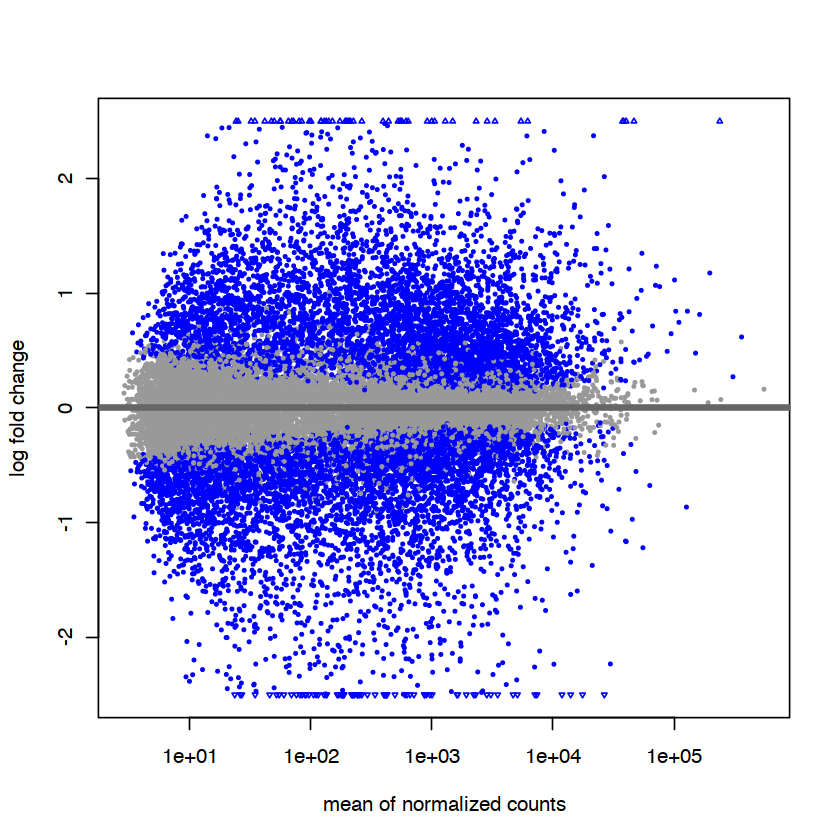

In [27]:
plotMA(res, ylim=c(-2.5, 2.5),)

Another popular visualization is called the `volcano` plot which compares the fold change with p-values. 

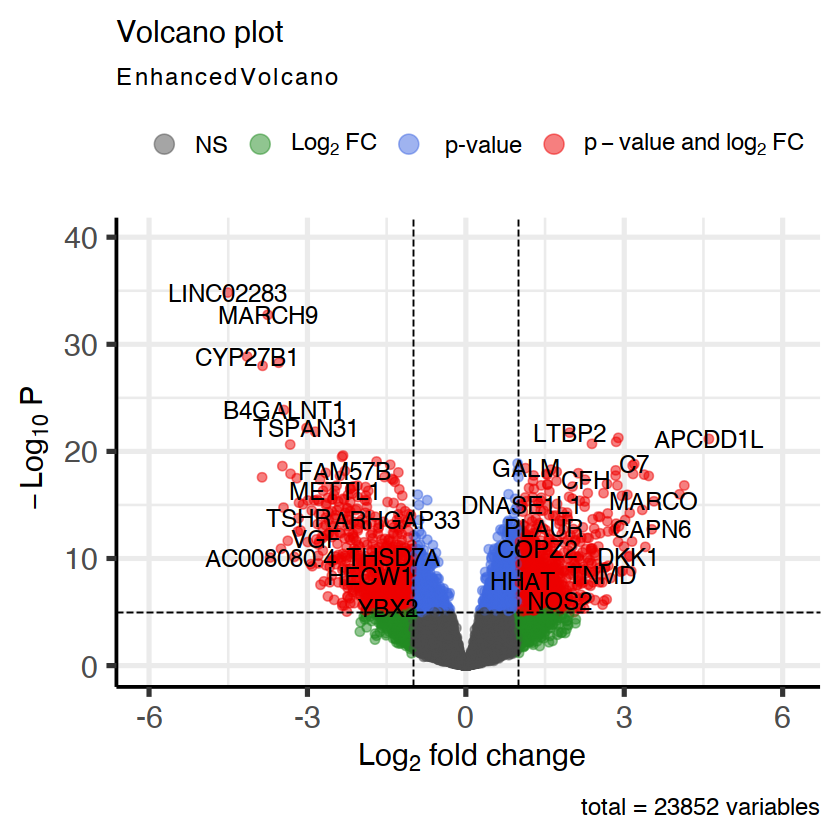

In [28]:
  EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue')


<b> Quick Exercise </b></br>
What can you say about differentially expressed genes in proneural and mesenchymal subtypes?

## A view behind the blackbox


![](assets/deseq2.jpg)

<b>Key points:</b></br>

* Each gene is modeled as a function of the specified conditions (See example below)
* Rather than fit a linear model on log counts, DESeq2 uses negative binomial distribution which models the underlying counts better. 
* In the model, greater slope implies greater difference 
* The dispersion estimates, representation of variance, is computed for each gene separately and information is shared across genes to derive a final estimate.

![](assets/lm.jpg)


<b> A fun exercise for later </b> </br>
Perform linear model fits for each gene using normalized log-transformed counts. Compare the slopes to the fold change estimates from DESeq2.


## Differential analysis - multiple conditions

Let us now consider the full dataset with all four conditions. Our goal is to identify differntially expressed genes in each condition relative to samples of all other conditions.


In [29]:
dds <- DESeqDataSet(gbmSE, design = ~ Subtype + 0)
dds <- DESeq(dds)


Warning message in DESeqDataSet(gbmSE, design = ~Subtype + 0):
"some variables in design formula are characters, converting to factors"
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  on

`contrasts` can be used to specify the comparisons of interest. Lets compare results using mesenchymal -vs- proneural comparison`

In [30]:
mes_vs_pro = results(dds, contrast=c("Subtype", "Mesenchymal", "Proneural"))
mes_vs_pro


log2 fold change (MLE): Subtype Mesenchymal vs Proneural 
Wald test p-value: Subtype Mesenchymal vs Proneural 
DataFrame with 23852 rows and 6 columns
            baseMean log2FoldChange     lfcSE      stat      pvalue        padj
           <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
TSPAN6     4046.9125      0.3443071 0.1532186  2.247163 2.46296e-02 5.99333e-02
TNMD         42.2759      3.5084674 0.4682303  7.493037 6.72977e-14 6.94885e-12
DPM1       1228.9732      0.0969099 0.1047546  0.925113 3.54907e-01 4.88490e-01
SCYL3       524.9035     -0.0892919 0.0737254 -1.211141 2.25841e-01 3.47389e-01
C1orf112    378.5120     -0.1566446 0.1202185 -1.302999 1.92575e-01 3.07738e-01
...              ...            ...       ...       ...         ...         ...
AL732314.6   9.53002      -0.723680  0.181430 -3.988747 6.64231e-05 0.000398272
AC018638.8  26.53033      -0.401566  0.224253 -1.790687 7.33436e-02 0.144144238
LINC02246    9.08608       0.322430  0.178458  1.

Compare to previous resuls 


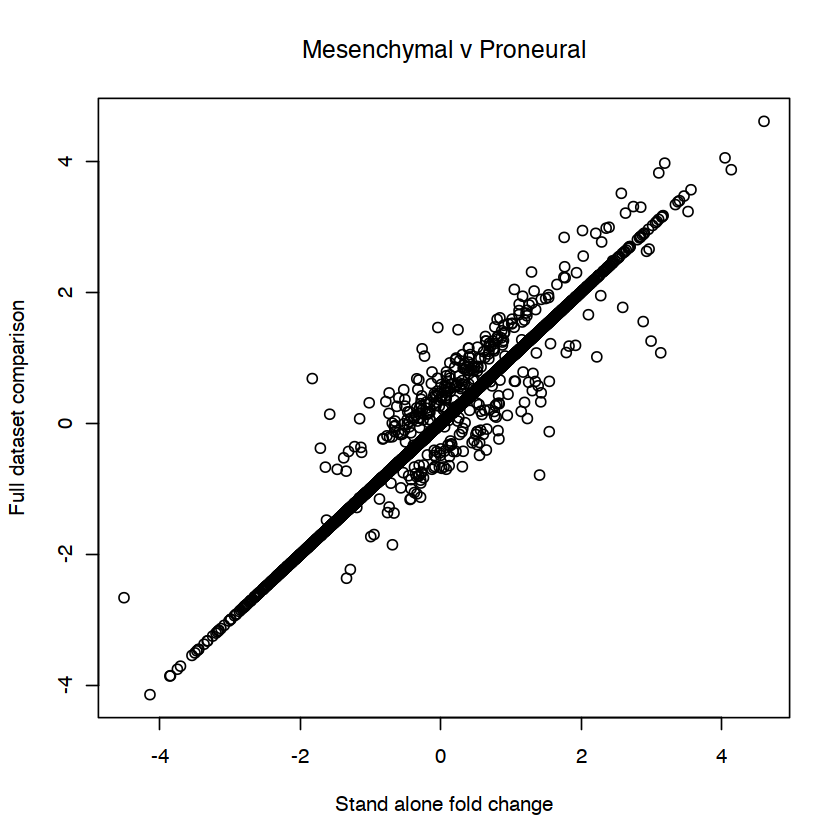

In [31]:
plot(res[, 'log2FoldChange'], 
     mes_vs_pro[rownames(res), 'log2FoldChange'], 
     xlab='Stand alone fold change', ylab='Full dataset comparison', 
     main='Mesenchymal v Proneural')


The `contrasts` can be vectors too!

In [32]:
# Key: Pay attention to the listValues parameter
mes_vs_rest = results(dds, contrast=list(
                                      c("SubtypeMesenchymal"), 
                                      c("SubtypeProneural", "SubtypeNeural", 'SubtypeG.CIMP')), 
                      listValues=c(1, -1/3))
mes_vs_rest


log2 fold change (MLE): SubtypeMesenchymal vs 0.333 SubtypeProneural+SubtypeNeural+SubtypeG.CIMP 
Wald test p-value: SubtypeMesenchymal vs 0.333 SubtypeProneural+SubtypeNeural+SubtypeG.CIMP 
DataFrame with 23852 rows and 6 columns
            baseMean log2FoldChange     lfcSE       stat      pvalue
           <numeric>      <numeric> <numeric>  <numeric>   <numeric>
TSPAN6     4046.9125     0.08579127 0.1357478  0.6319903 5.27393e-01
TNMD         42.2759     2.70131316 0.4129776  6.5410639 6.10827e-11
DPM1       1228.9732     0.00589718 0.0928088  0.0635412 9.49336e-01
SCYL3       524.9035    -0.18410170 0.0652893 -2.8197841 4.80560e-03
C1orf112    378.5120    -0.05783907 0.1066061 -0.5425491 5.87440e-01
...              ...            ...       ...        ...         ...
AL732314.6   9.53002     -0.4749233  0.163910  -2.897472 0.003761836
AC018638.8  26.53033     -0.0481320  0.199672  -0.241056 0.809512053
LINC02246    9.08608      0.4511443  0.161391   2.795358 0.005184227
LINC01144 

Compare to mesenchymal -vs- proneural resuls 

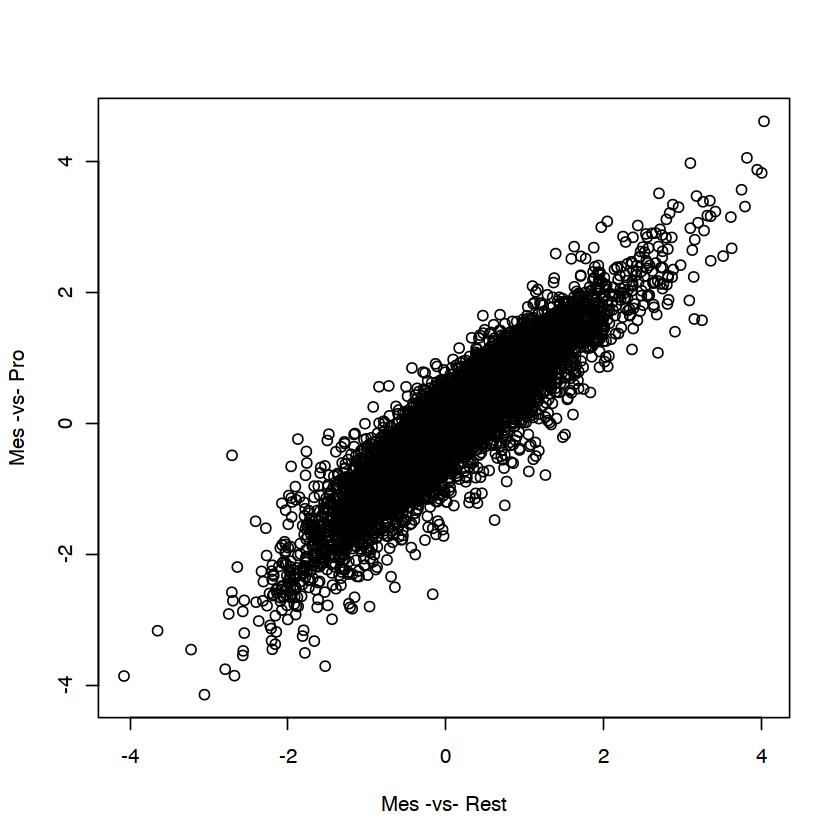

In [33]:
plot(mes_vs_rest[, 'log2FoldChange'], 
     mes_vs_pro[rownames(res), 'log2FoldChange'], 
     xlab='Mes -vs- Rest', ylab='Mes -vs- Pro', 
     )


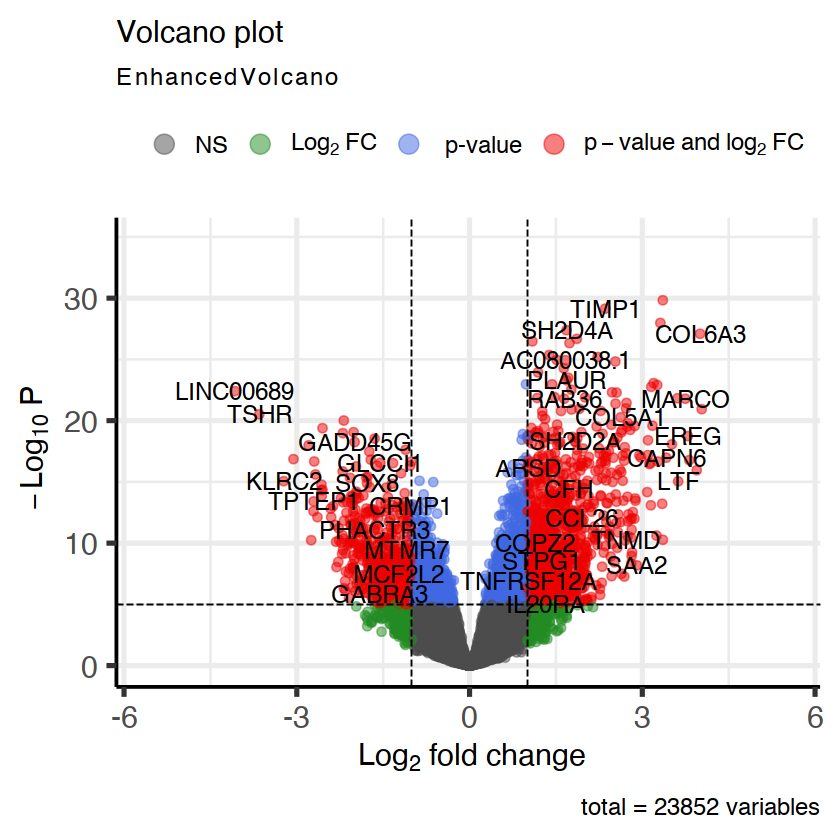

In [34]:
  EnhancedVolcano(mes_vs_rest,
    lab = rownames(mes_vs_rest),
    x = 'log2FoldChange',
    y = 'pvalue')


<b> Quick Exercise </b> </br>
Perform analysis of proneural -vs- rest and compare to proneural -vs- mesenchymal results.


## Differential analysis - technical differences
Often times, data are generated in multiple batches or different settings (E.g: single-end -vs- paired-end reads). These technical differences can lead to artifical differences between biological conditions. Such technical variables can be accounted for using DESeq by specifying them when constructing the `DESeqDataSet` object. 


``dds <- DESeqDataSet(gbmSE, design = ~ batch + Subtype + 0)``

## Gene Ontology analysis

Gene ontology or pathway enrichments can be used to understand the collective behaviour of differentially expressed genes. The goal of this analysis is to check if the differentially expressed genes are enriched in certain known pathways, cell types, or biological processes.

![](assets/hypergeom.jpg)

There are a number of interesting gene sets available for exploration. [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) by the Broad Institute is an excellent source of these databases. MSigDB also has a simple interface to test for enrichments among differentially expressed genes.

Gene ontology analysis can be performed using the `goseq` package. 

First, extract the genes that are significantly high in proneural -vs- mesenchymal comparison with a `fold change > 2` and adjusted `p-value < 1e-2`


Loading hg19 length data...

Fetching GO annotations...



ERROR: Error in library(paste(orgstring, "db", sep = "."), character.only = TRUE): there is no package called 'org.Hs.eg.db'


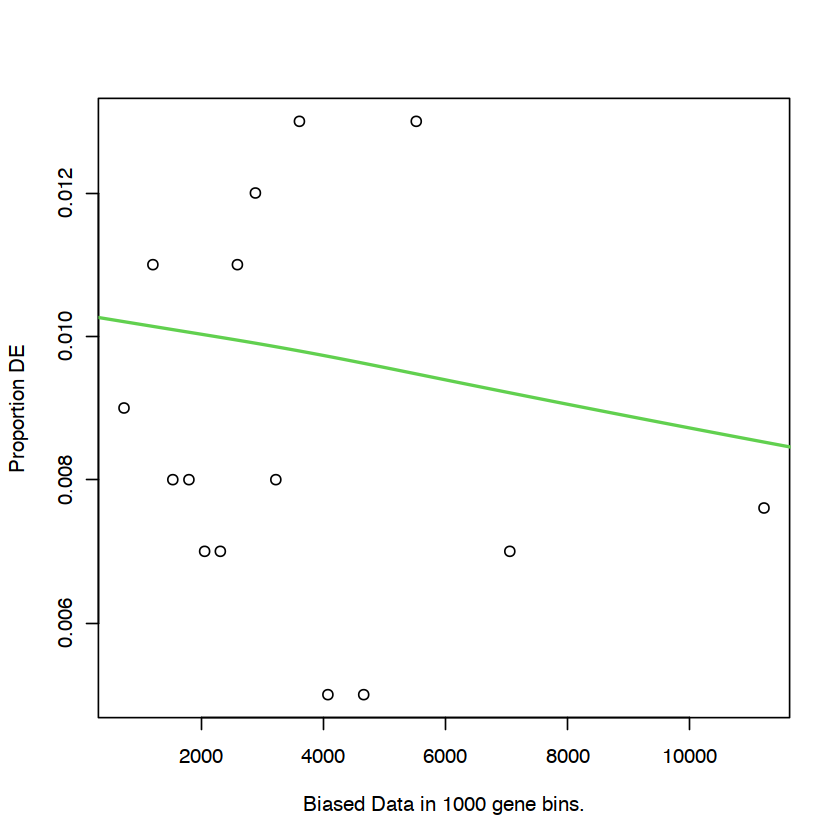

In [37]:
# Binary vector indicating which gene is significant
proneural_genes = ((mes_vs_pro_pairwise[, 'log2FoldChange'] < -2) & (mes_vs_pro_pairwise[, 'padj'] < 1e-2))
names(proneural_genes) <- rownames(mes_vs_pro_pairwise)

# Setup background for goseq
pwf <- nullp(proneural_genes, 'hg19', 'geneSymbol')
enriched_pathways <- goseq(pwf, 'hg19', 'geneSymbol', test.cats='GO:BP')
head(enriched_pathways)


<b> Quick exercise </b></br>

In [ ]:
# Repeat the above analysis for mesenchymal genes in the mes -vs- pro pairwise comparison

# Visualization

Differential analysis was performed on the raw counts. For visualization and measuring distances between samples, we will need to account for the following factors

* Total reads or fragments between samples can be very different and therefore, the data needs to be normalized
* Variance is a function of the mean in count data types and therefore needs to be stabilized. 

`Variance stabilizing transformation (vst)` is a very effective way to achieve these. More details can be found [here](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#count-data-transformations). `vst` can be performed using:


In [38]:
vsd <- vst(dds, blind=FALSE)

## Heatmap of gene expression

Heatmaps are a very powerful way to visualize the data and understand the relationships between samples. We will extract the top 100 genes for each subtype compared to the rest of the subtype and plot the expression of these genes on a heatmap.


First, extract the top 100 genes for each condition


In [39]:
n_genes <- 100
genes <- c()
subtypes <- c('SubtypeProneural', 'SubtypeMesenchymal', 
                'SubtypeNeural', 'SubtypeG.CIMP')
for (subtype in subtypes){
    subtype_res = results(dds, contrast=list(
                                      c(subtype), 
                                      setdiff(subtypes, c(subtype))), 
                      listValues=c(1, -1/3))
    
    resOrdered <- subtype_res[order(subtype_res$padj),]
    subtype_genes <- rownames(resOrdered[resOrdered[, 'log2FoldChange'] > 0,  ])[1:n_genes]
    genes <- c(genes, subtype_genes)

}


Second, create a matrix containing the above set of genes and all samples. It is highly recommended to z-score (subtract the mean, divide by standard deviation across samples) the expression values for highlighting the contrasts

In [40]:
norm_matrix <- assay(vsd[genes, ])
scaled_exprs <- t(scale(t(norm_matrix)))
scaled_exprs[scaled_exprs > 2] = 2
scaled_exprs[scaled_exprs < -2] = -2


Finally, plot the heatmap!

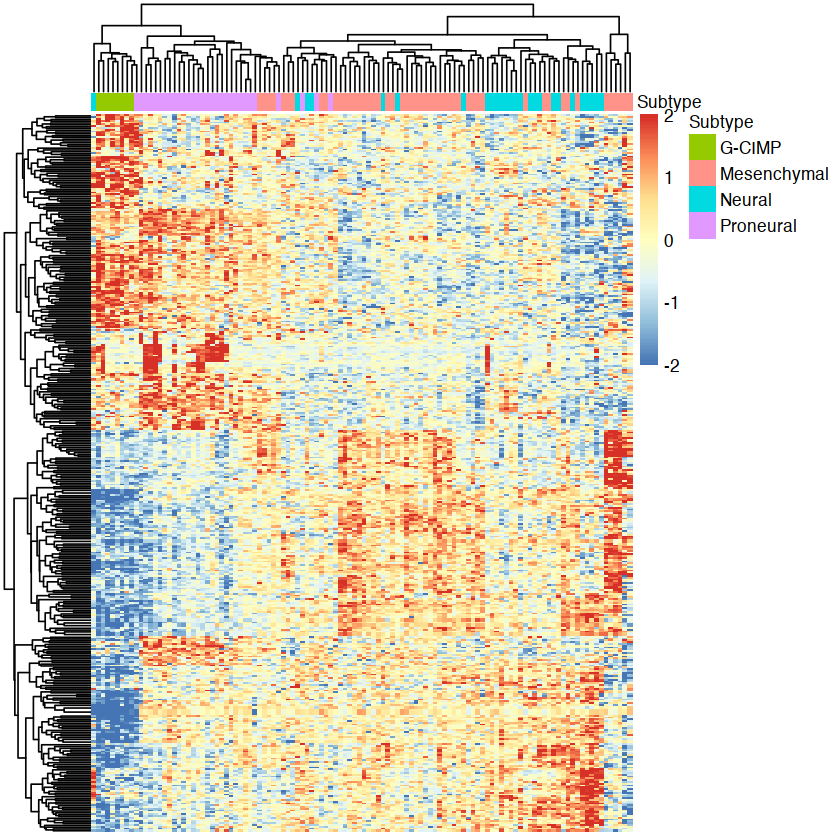

In [41]:
df <- as.data.frame(colData(dds)[,"Subtype"])
colnames(df) = 'Subtype'
rownames(df) <- colnames(dds)
pheatmap(scaled_exprs, cluster_rows=TRUE, 
         show_rownames=FALSE, show_colnames=FALSE,
         cluster_cols=TRUE, annotation_col=df)


What are your observations?

## Heatmap of sample to sample distances

Lets use the subset of genes identified to find distances between samples and plot them as a heatmap.


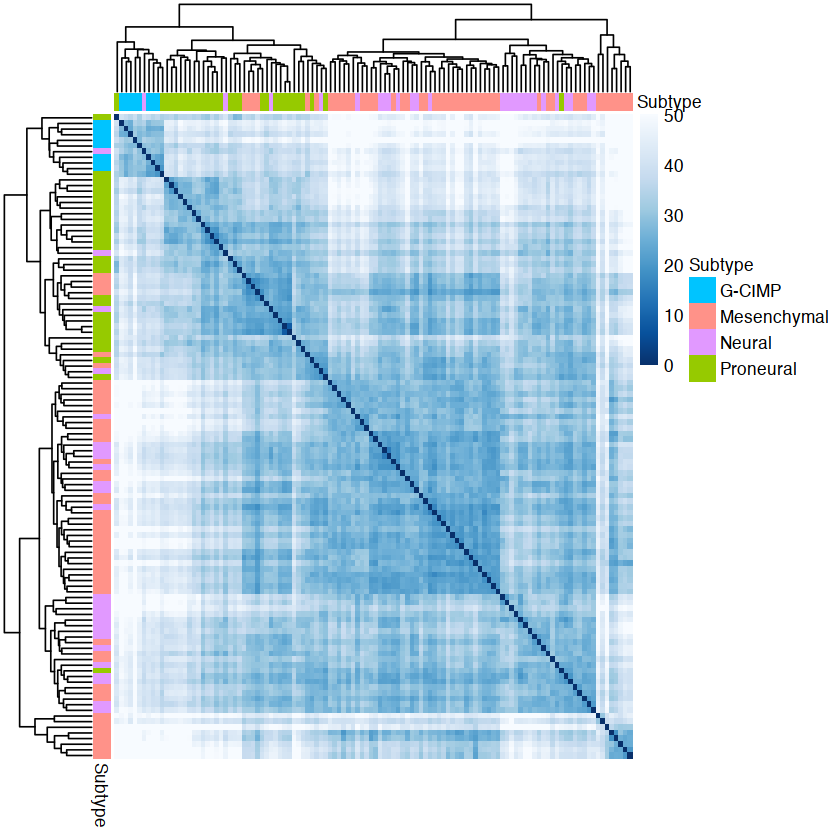

In [42]:
# Compute distances 
sampleDists <- dist(t(norm_matrix))
sampleDistMatrix <- as.matrix(sampleDists)
sampleDistMatrix[sampleDistMatrix > 50] = 50

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         show_rownames=FALSE, show_colnames=FALSE,
         annotation_col=df, annotation_row=df)


<b>Quick exercise</b> </br>
Generate heatmap using all genes


## PCA
Visualizing using PCA can be very effective when dealing with a large number of samples. The following function plots the first two components.


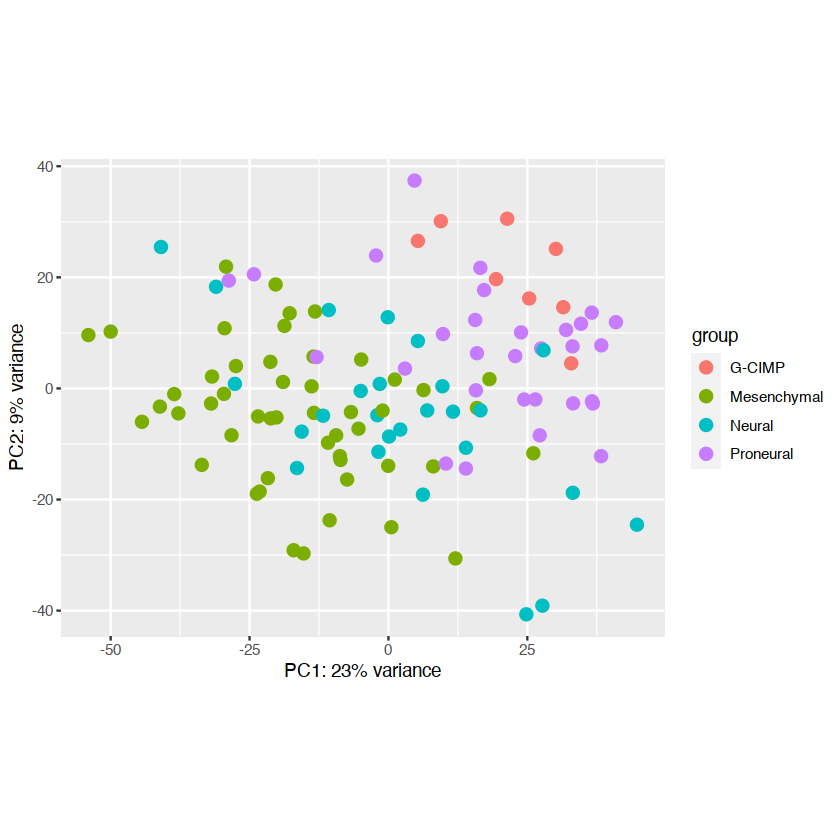

In [43]:
plotPCA(vsd, intgroup=c("Subtype"))

<b> A fun exercise for later </b> </br>

 * Train a classifier between a pair of subtypes or all cell types. 
 * Identify the genes that are most informative for the classification 
 * Compare the results to differential analysis between the same pair of subtypes 
 * What do you think are the advantages and disadvantages of using classification instead of differential analysis. 

